# Traffic Sign Recognition using Deep Learning
## A Comprehensive Analysis of CNN Architectures for Traffic Sign Classification

### Project Overview
This notebook implements and analyzes various deep learning approaches for traffic sign recognition, comparing different architectures and evaluating their real-world applicability. The project demonstrates both theoretical understanding and practical considerations for production deployment.

### Import Required Libraries

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import sys
import time
import psutil
from datetime import datetime
import tqdm
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, MobileNetV2 # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from concurrent.futures import ThreadPoolExecutor
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

### Configuration Parameters

In [18]:
IMG_WIDTH=48
IMG_HEIGHT=48
EPOCHS=30
NUM_CATEGORIES=43
TEST_SIZE=0.2
BATCH_SIZE=32


## Exploratory Data Analysis (EDA)
In this section, we will explore the GTSRB dataset to understand the distribution of classes, inspect sample images, and analyze key attributes such as shape and color of traffic signs. This analysis will help guide preprocessing and modeling decisions.

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = '/content/drive/MyDrive/archive/'
train_path = data_path + 'Train/'
test_path = data_path + 'Test/'
df_meta = pd.read_csv(data_path + 'Meta.csv')
df_train = pd.read_csv(data_path + 'Train.csv')
df_test = pd.read_csv(data_path + 'Test.csv')

In [11]:
df_train.shape

(39209, 8)

In [6]:
df_test.shape

(12630, 8)

In [7]:
df_train.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [8]:
df_test.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [9]:
df_meta.head()

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


In [10]:
print("Min. Class Label: {}".format(df_meta.ClassId.min()))
print("Max Class Label: {}".format(df_meta.ClassId.max()))
print("Total Class Labels: {}".format(len(df_meta.ClassId.unique())))

Min. Class Label: 0
Max Class Label: 42
Total Class Labels: 43


In [13]:
num_classes = len(df_meta.ClassId.unique())
class_dict = {}
class_labels = list(range(num_classes))
# Speed Class 0-9
speed_class = ['Speed Limit ' + item for item in [speed + ' kmph' for speed in ['20', '30', '50', '60', '70', '80']]]\
            + ['End of Speed Limit 80 kmph']
speed_class+= ['Speed Limit ' + item for item in [speed + ' kmph' for speed in ['100', '120']]]
speed_class
# 10, 11 No Passing
no_pass = ['No Passing' + item for item in ['', ' vehicle over 3.5 ton']]
# 12-43
rest = ['Right-of-way at intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Veh > 3.5 tons prohibited',\
            'No entry', 'General caution', 'Dangerous curve left', 'Dangerous curve right', 'Double curve', 'Bumpy road',
            'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing',
            'Bicycles crossing', 'Beware of ice/snow','Wild animals crossing', 'End speed + passing limits', 'Turn right ahead',
            'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left',
            'Roundabout mandatory', 'End of no passing', 'End no passing vehicle > 3.5 tons']
class_values = speed_class + no_pass + rest
class_dict = {keys:values for keys,values in zip(class_labels, class_values)}

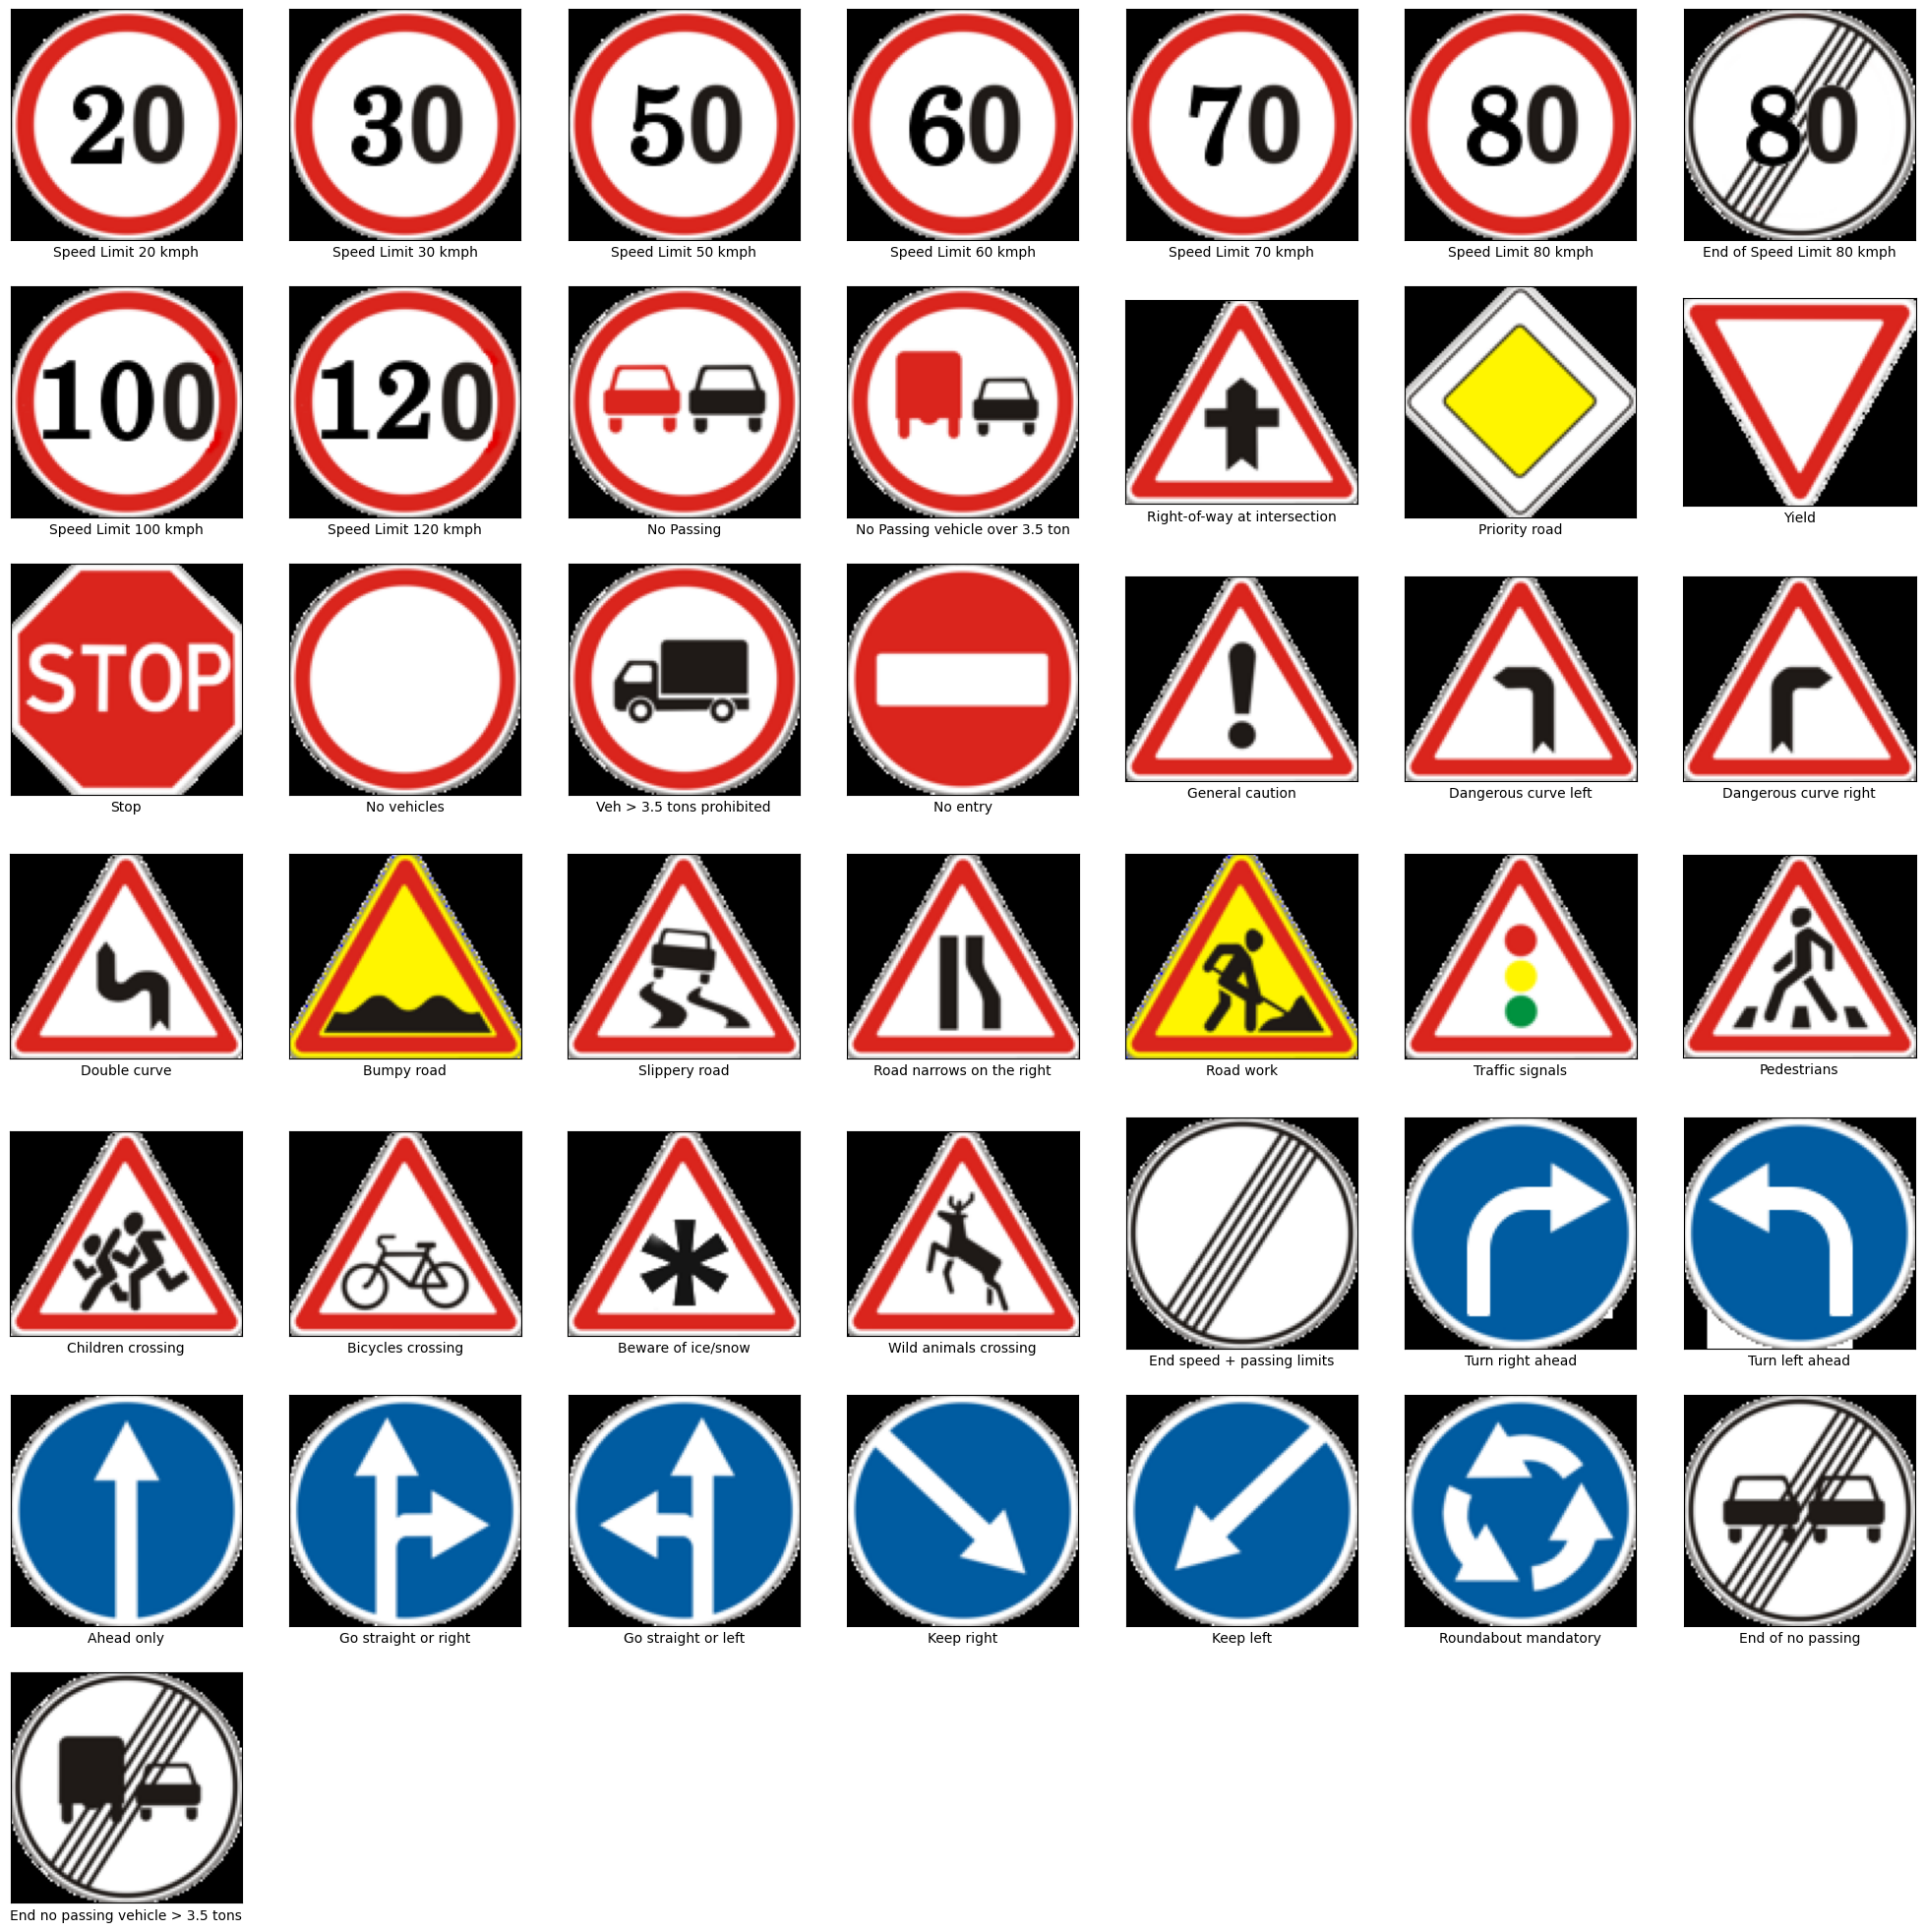

In [12]:
sortFunction = lambda x: int(os.path.basename(x)[:-4])
plt.figure(figsize = (25, 25))
for i, imagename in enumerate(sorted(glob.glob(data_path + 'Meta/' + '*.*'), key = sortFunction)):
    plt.subplot(7, 7, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_dict[i])
    image = cv2.imread(imagename)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [13]:
shape_dict = {0: 'Triangle', 1: 'Circle', 2: 'Diamond', 3: 'Hexagon', 4: 'Inverse Triangle'}
df_meta.ShapeId.value_counts()

,count
ShapeId,
1,25
0,15
2,1
4,1
3,1


In [14]:
def visualize_shape(shape = 0):
    """
    Plots random samples of a particular shape from shape_dict
    """
    filenames = df_meta[df_meta.ShapeId==shape].sample(10).Path
    plt.figure(figsize = (25, 25))
    for i, filename in enumerate(data_path + filenames):
        image = cv2.imread(filename)
        plt.subplot(11, 4, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

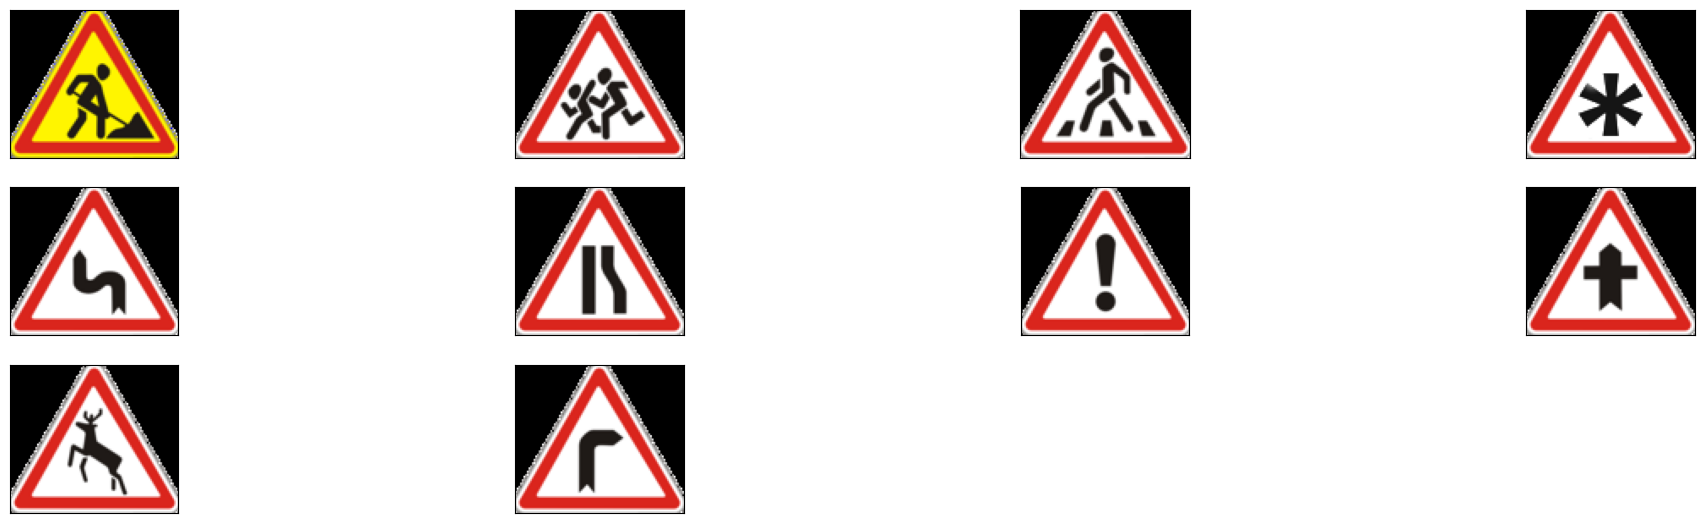

In [15]:
visualize_shape(0) #Traffic signs in Triangular shape

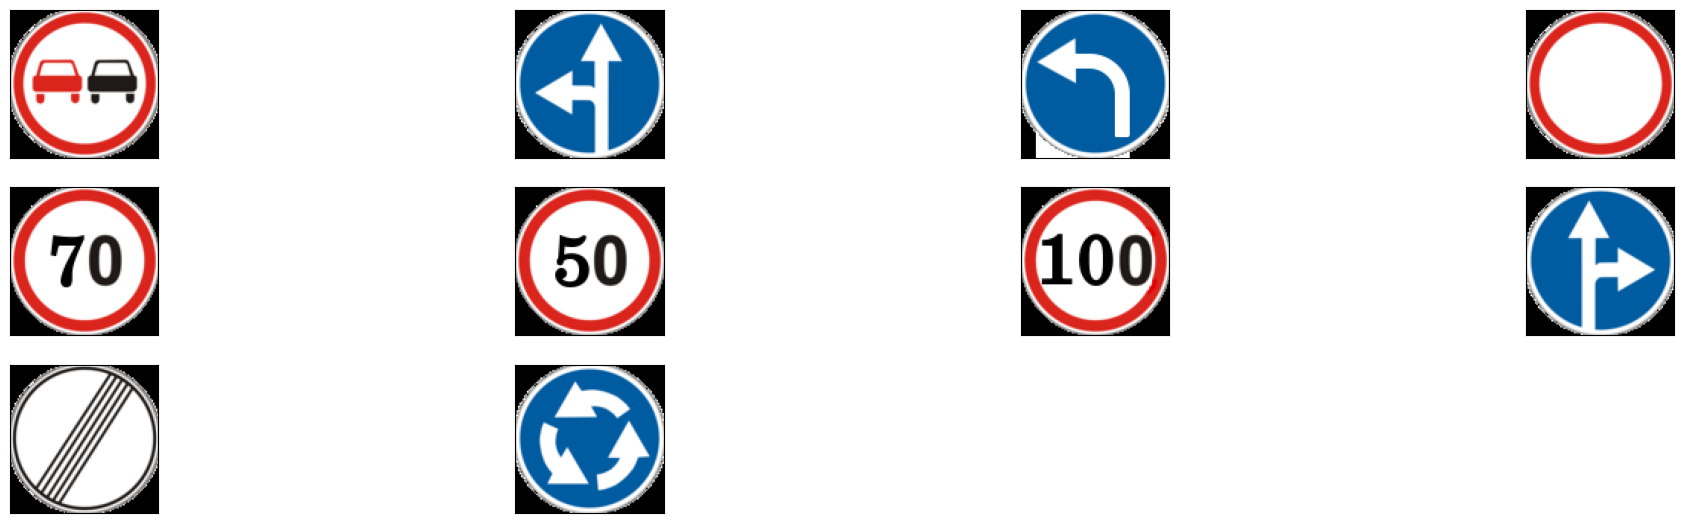

In [16]:
visualize_shape(1) #Traffic signs in circular shape

In [17]:
color_dict = {0:'Red', 1:'Blue', 2:'Yellow', 3:'White'}
df_meta.ColorId.value_counts()

,count
ColorId,
0,30
1,8
3,4
2,1


In [18]:
def visualize_color(color = 0):
    """
    Plots random samples of a particular color from color_dict
    """
    filenames = df_meta[df_meta.ColorId==color].sample(5).Path
    plt.figure(figsize = (20, 20))
    for i, filename in enumerate(data_path + filenames):
        image = cv2.imread(filename)
        plt.subplot(1, 6, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

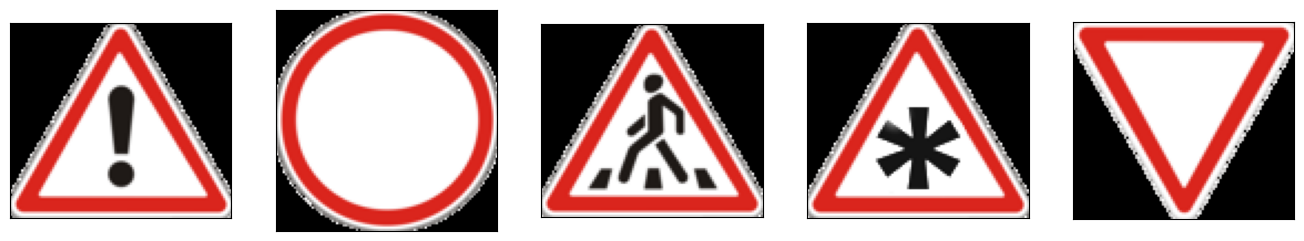

In [19]:
#  Visualize Red Colored Traffic Signs, color = 0
visualize_color(color = 0)

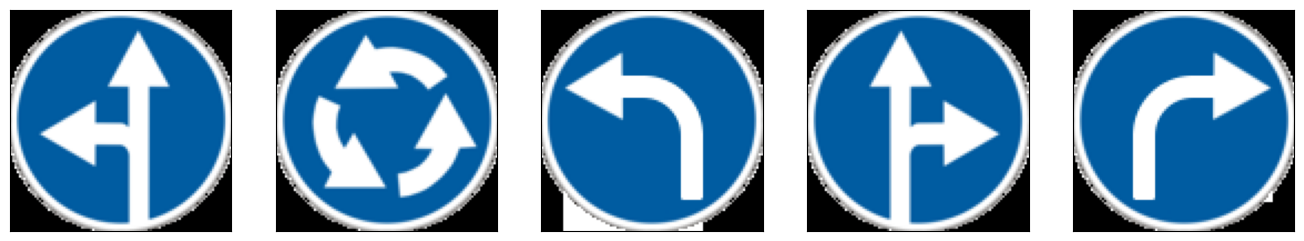

In [20]:
#  Visualize Blue Colored Traffic Signs, color = 1
visualize_color(color = 1)

In [ ]:
df_train.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000


In [22]:
df_train.ClassId.value_counts()

,count
ClassId,
2,2250
1,2220
13,2160
12,2100
38,2070
10,2010
4,1980
5,1860
25,1500


In [4]:
# Create a dictionary which consists of the labels as keys and the number of samples as values
train_dict = {}
train_dict = {keys:values for keys,values in zip(df_train.ClassId.value_counts().index, df_train.ClassId.value_counts().tolist())}

In [24]:
class_values[0]

'Speed Limit 20 kmph'

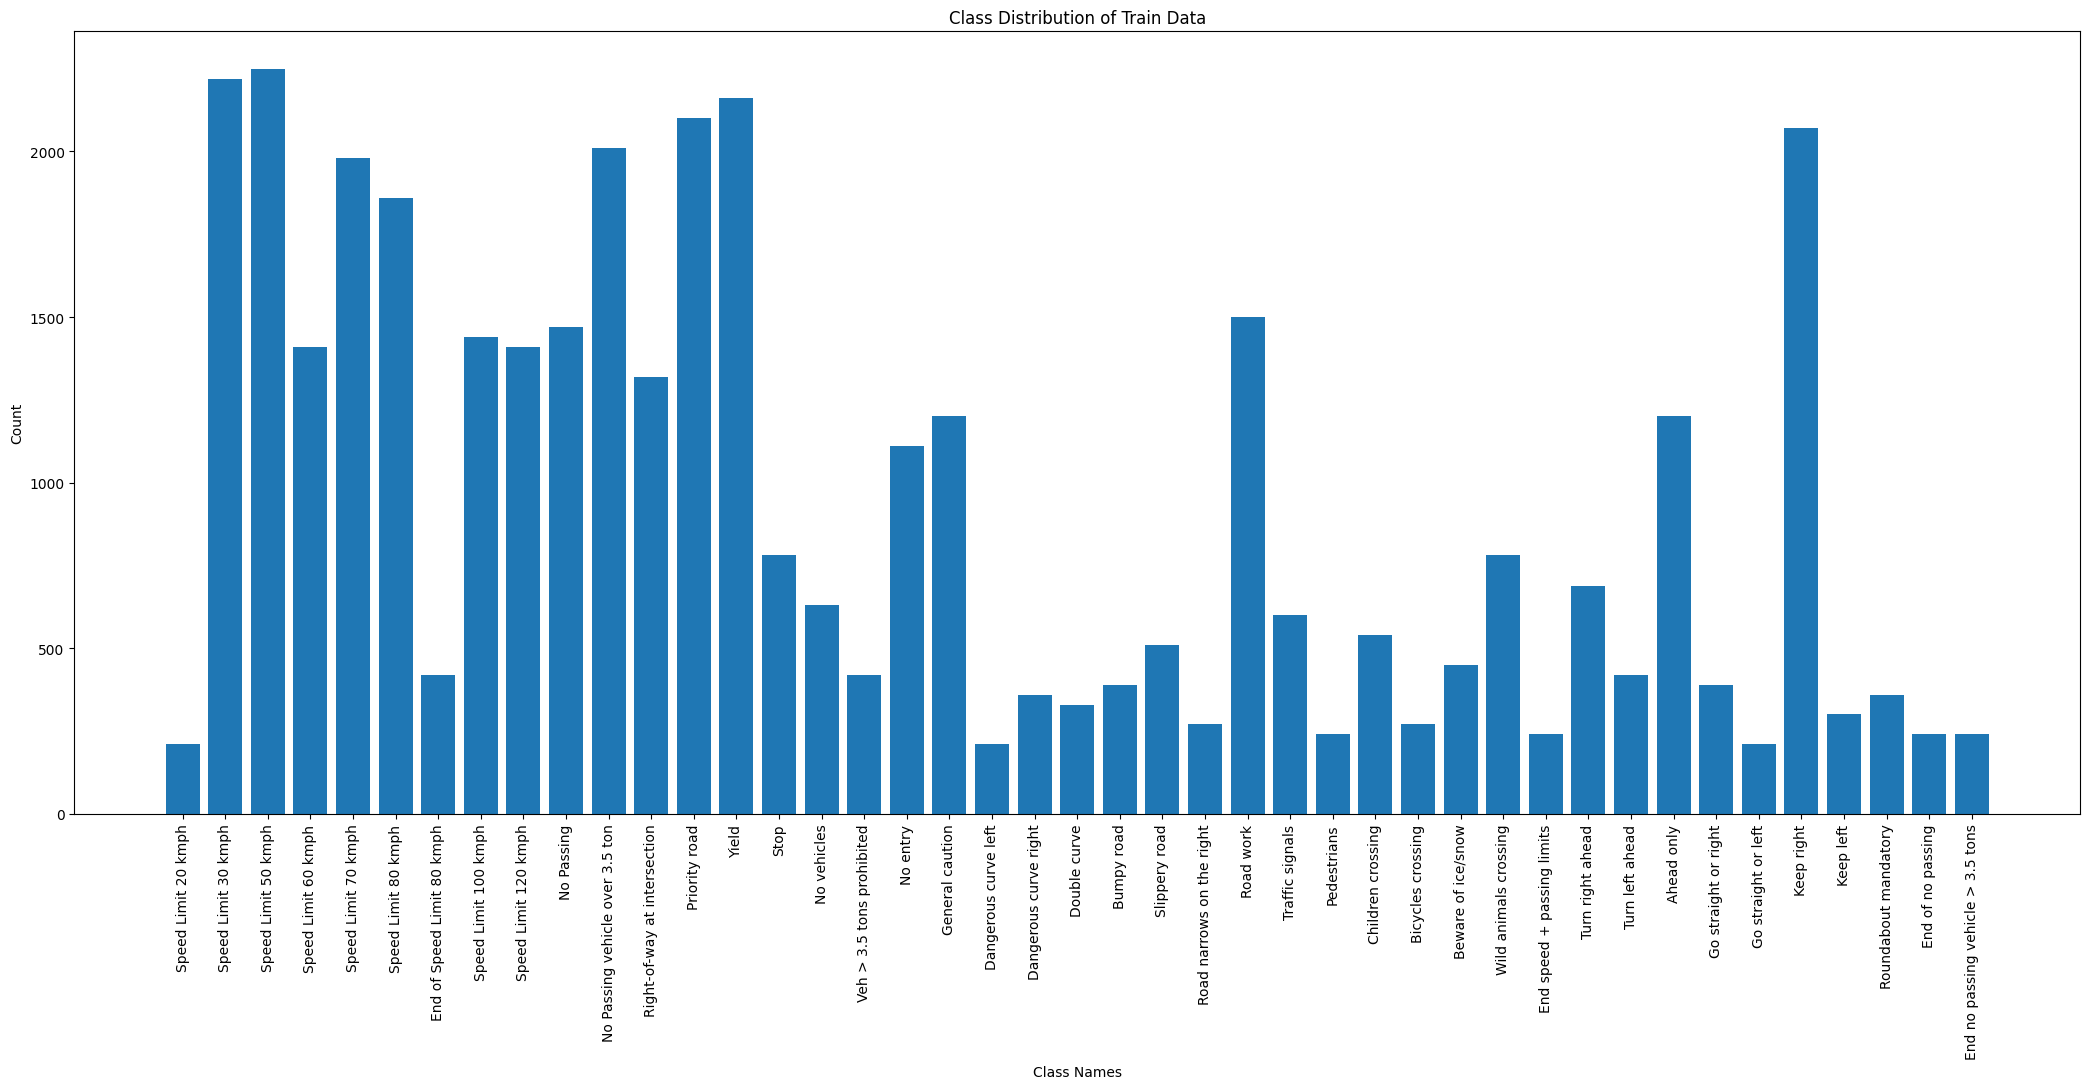

In [25]:
import matplotlib.pyplot as plt

# Sort keys to ensure correct order
sorted_keys = sorted(train_dict.keys())
sorted_values = [train_dict[k] for k in sorted_keys]
sorted_labels = [class_values[k] for k in sorted_keys]

plt.figure(figsize=(21, 11))
plt.bar(sorted_keys, sorted_values)
plt.title("Class Distribution of Train Data")

# Set properly ordered labels
plt.xticks(ticks=sorted_keys, labels=sorted_labels, rotation=90)

plt.xlabel("Class Names")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [5]:
# Check the dataframe information with folder directory
train_folders = os.listdir(train_path)
# Create a dict with keys as label names and the number of images present inside each label folder as values
sample_dict = {}
for folders in train_folders:
    images = os.listdir(train_path + folders)
    sample_dict[folders] = len(images)
train_sample_dict = {int(k):v for k,v in zip(sample_dict.keys(), sample_dict.values())}
train_dict==train_sample_dict

True

**We have verified that the number of images in the respective classes in training folder and train.csv are matching**

In [27]:
df_test.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000
mean,50.507759,50.364450,5.998021,5.982423,44.864450,44.758116,15.551069
std,25.088483,23.698908,1.543954,1.427424,23.776102,22.494697,11.947123
min,25.000000,25.000000,1.000000,5.000000,20.000000,20.000000,0.000000
25%,34.000000,35.000000,5.000000,5.000000,29.000000,29.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,57.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,266.000000,232.000000,23.000000,19.000000,244.000000,212.000000,42.000000


In [ ]:
df_test.ClassId.value_counts()

,count
ClassId,
2,750
13,720
1,720
38,690
12,690
4,660
10,660
5,630
25,480


In [6]:
# Create a test_dict with keys as the labels and values as the value_counts
test_dict = {}
test_dict = {keys:values for keys,values in zip(df_test.ClassId.value_counts().index, df_test.ClassId.value_counts().tolist())}

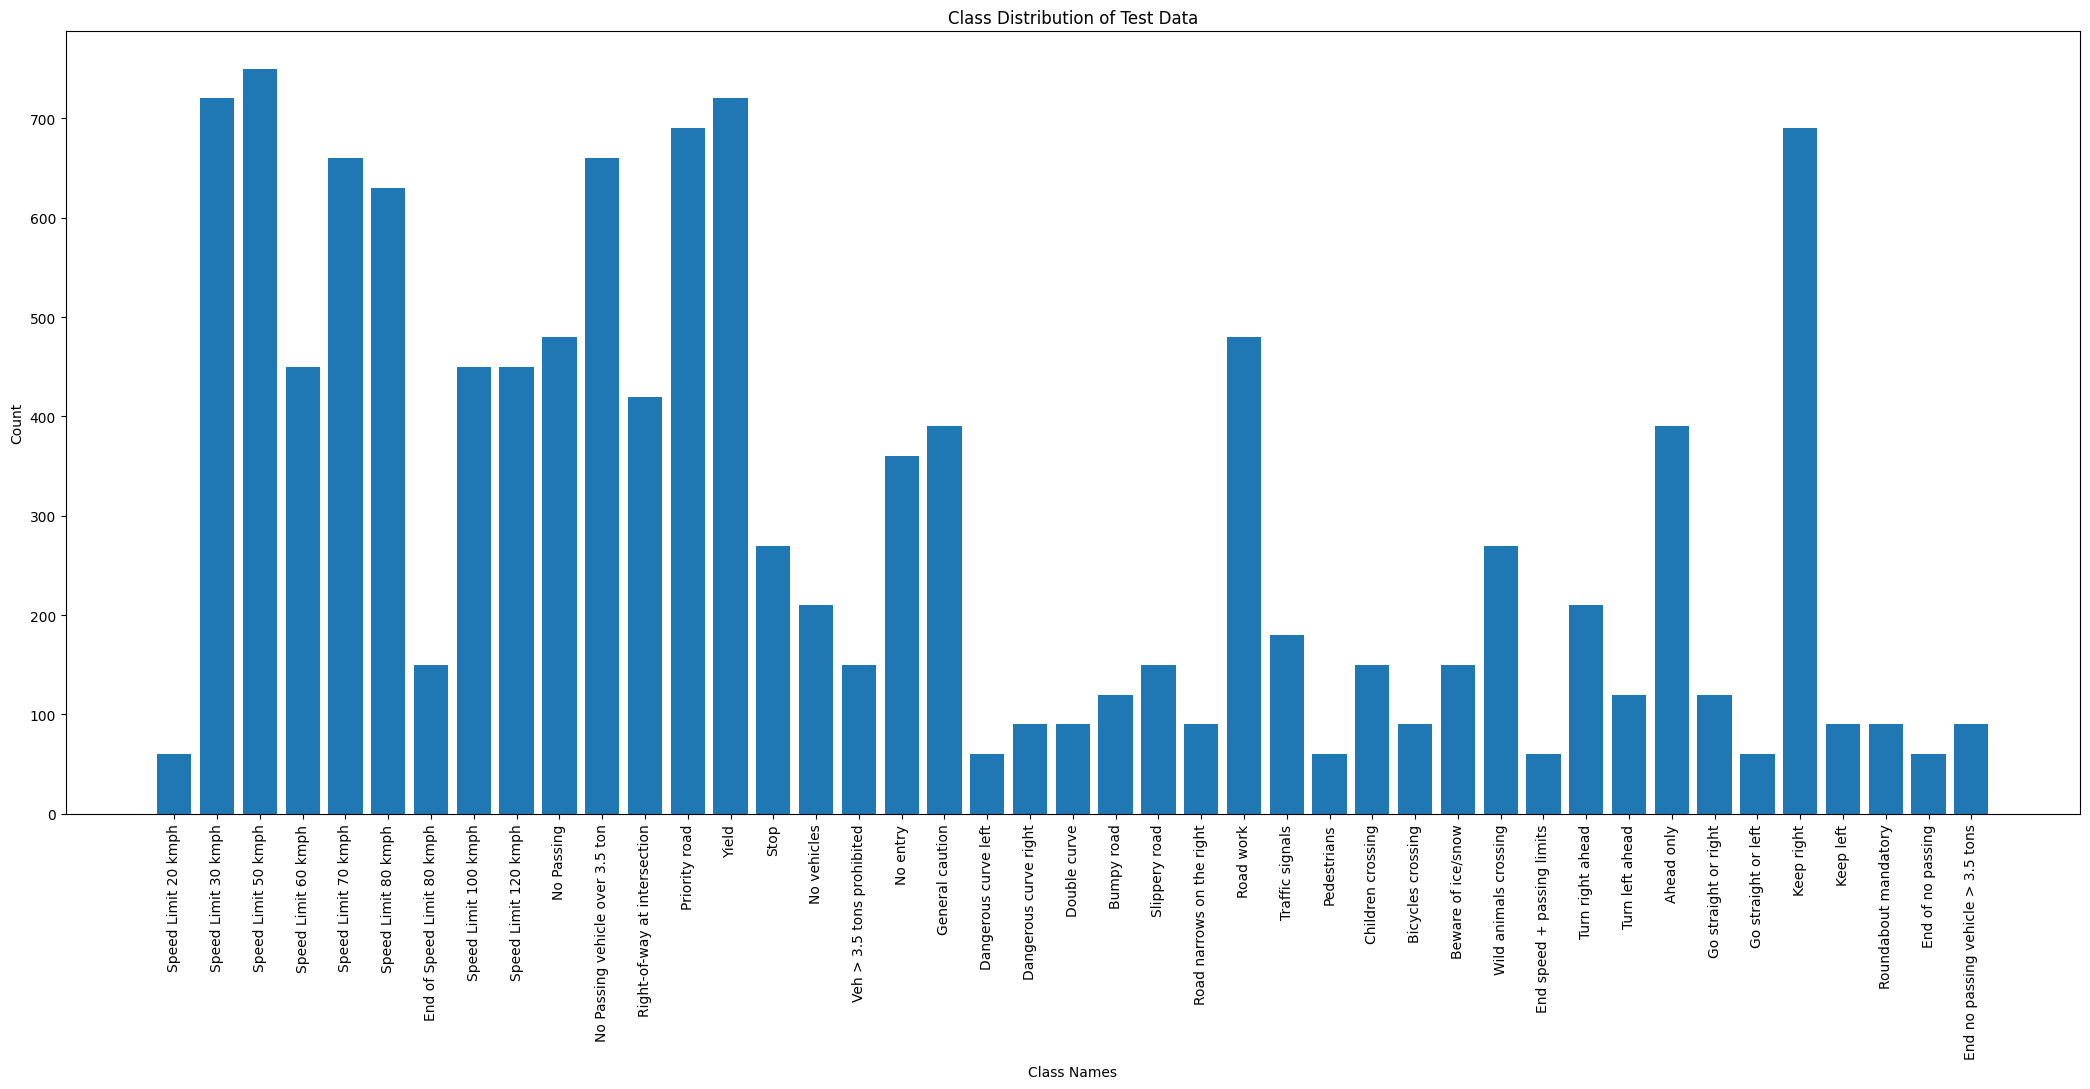

In [ ]:
# Sort keys to ensure correct order
sorted_keys = sorted(test_dict.keys())
sorted_values = [test_dict[k] for k in sorted_keys]
sorted_labels = [class_values[k] for k in sorted_keys]

plt.figure(figsize=(21, 11))
plt.bar(sorted_keys, sorted_values)
plt.title("Class Distribution of Test Data")

# Set properly ordered labels
plt.xticks(ticks=sorted_keys, labels=sorted_labels, rotation=90)

plt.xlabel("Class Names")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [28]:
df_balance = pd.DataFrame()
df_balance['labels'] = list(range(43))
df_balance['train'] = train_dict.values()
df_balance['test'] = test_dict.values()
df_balance['total'] = df_balance['train'] + df_balance['test']
df_balance['train_ratio'] = df_balance['train']/df_balance['total']
df_balance['test_ratio'] = df_balance['test']/df_balance['total']

In [ ]:
df_balance.head(10)

,labels,train,test,total,train_ratio,test_ratio
0,0,2250,750,3000,0.750000,0.250000
1,1,2220,720,2940,0.755102,0.244898
2,2,2160,720,2880,0.750000,0.250000
3,3,2100,690,2790,0.752688,0.247312
4,4,2070,690,2760,0.750000,0.250000
5,5,2010,660,2670,0.752809,0.247191
6,6,1980,660,2640,0.750000,0.250000
7,7,1860,630,2490,0.746988,0.253012
8,8,1500,480,1980,0.757576,0.242424
9,9,1470,480,1950,0.753846,0.246154


<Axes: title={'center': 'Train Test Ratio for each class'}, xlabel='labels'>

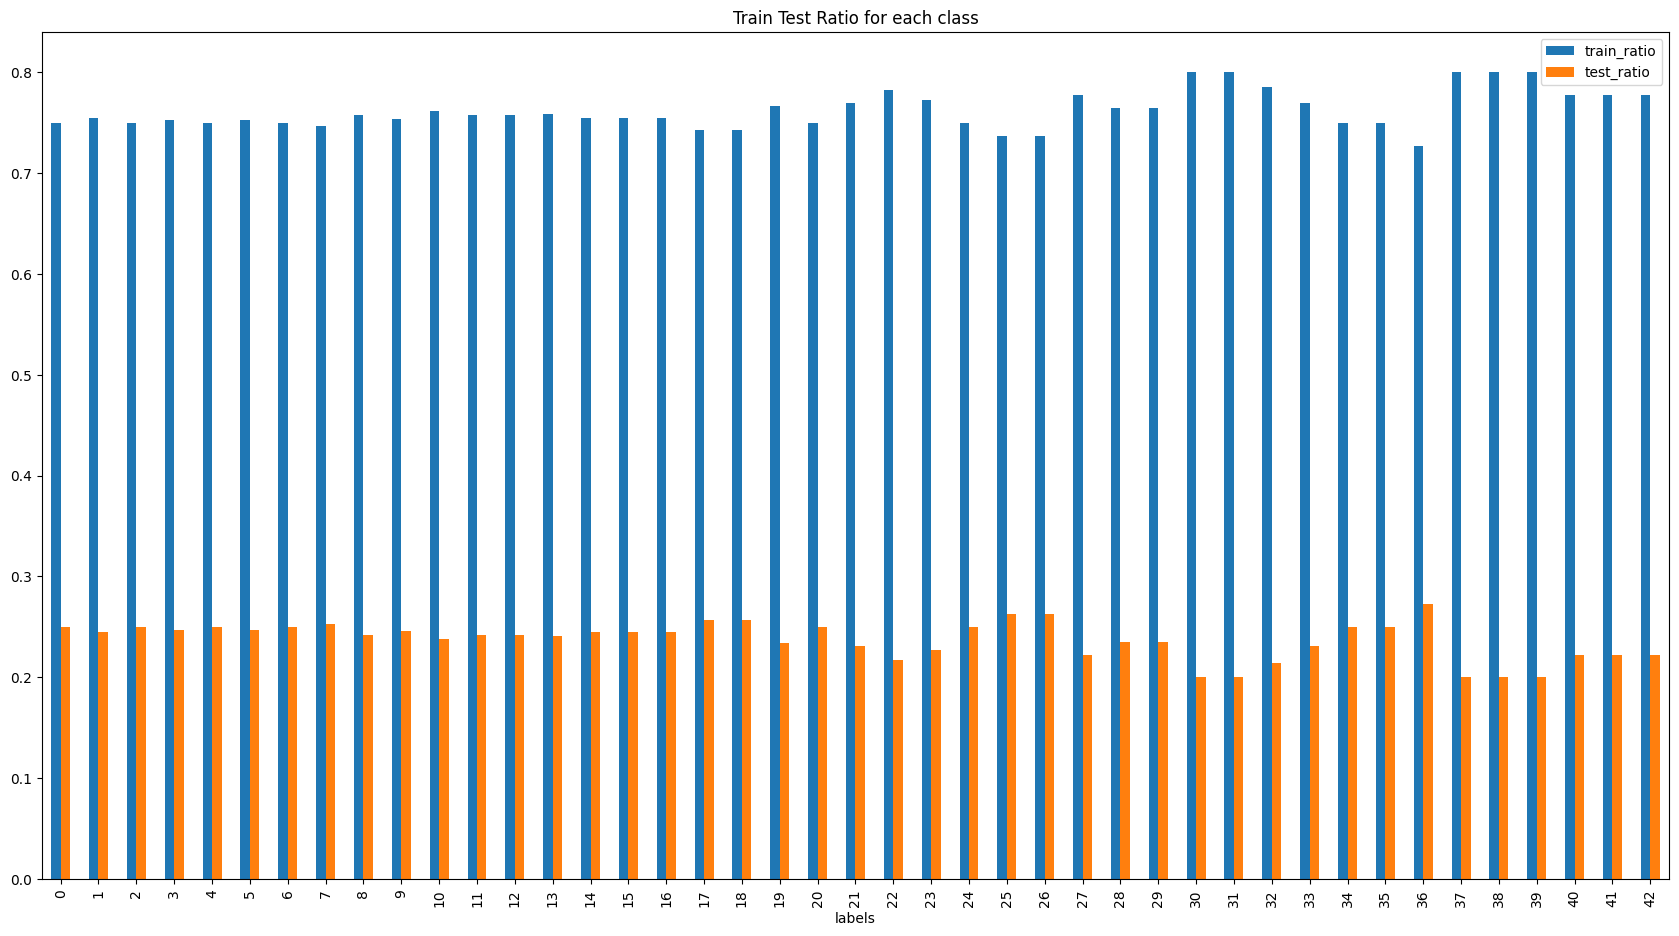

In [ ]:
df_balance.plot(x = 'labels', y = ['train_ratio', 'test_ratio'], kind = 'bar', figsize = (21, 11), title = "Train Test Ratio for each class")

## EDA Observations and Key Takeaways

1. Dataset Structure & Class Distribution:
    - The dataset contains 43 traffic sign classes, as confirmed by df_meta and class_values.
    - Both train and test splits are well represented, but there is some class imbalance (see train_dict, test_dict, and bar plots).
    - The number of images in each class folder matches the counts in train.csv, confirming data integrity.

2. Visual Diversity:
    - Traffic signs exhibit diverse shapes (Triangle, Circle, Diamond, Hexagon, Inverse Triangle) and colors (Red, Blue, Yellow, White).
    - Visualizations show that certain shapes and colors dominate specific classes.

3. Data Splitting:
    - After splitting, class distributions in train and validation sets remain similar due to stratification.
    - The df_balance DataFrame and related plots confirm that the train, validation, and test splits are proportionally distributed.

4. Image Properties:
    - All images are resized to 48x48 pixels and normalized for model input.
    - The dataset is sufficiently large for deep learning, but some minority classes may require augmentation.

5. Takeaways:
    - Address class imbalance with targeted augmentation for minority classes.
    - The dataset is clean and well-structured, suitable for training robust CNN and transfer learning models.


In [ ]:
def load_and_preprocess_image(img_path):
    """Fast image loading and preprocessing"""
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if image is None:
        return None
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    return image / 255.0

# --- Collect all train image paths and labels ---
all_paths, all_labels = [], []

print(f"Processing {len(train_folders)} folders...")
for folder in train_folders:
    folder_path = os.path.join(train_path, folder)
    if not os.path.exists(folder_path):
        print(f"Missing folder: {folder_path}")
        continue
    files = os.listdir(folder_path)
    for file in files:
        all_paths.append(os.path.join(folder_path, file))
        all_labels.append(int(folder))

print(f"Total images collected: {len(all_paths)}")

# --- Multithreaded loading function ---
def load_images_parallel(paths):
    with ThreadPoolExecutor(max_workers=16) as executor:
        results = list(executor.map(load_and_preprocess_image, paths))
    return results

# --- Load training data in parallel ---
train_data, train_labels = [], []

chunk_size = 2000
total_chunks = (len(all_paths) + chunk_size - 1) // chunk_size

for i in tqdm.tqdm(range(0, len(all_paths), chunk_size), desc="Loading train images", total=total_chunks):
    chunk_paths = all_paths[i:i+chunk_size]
    chunk_labels = all_labels[i:i+chunk_size]

    chunk_images = load_images_parallel(chunk_paths)

    for img, lbl in zip(chunk_images, chunk_labels):
        if img is not None:
            train_data.append(img)
            train_labels.append(lbl)

train_data = np.array(train_data, dtype=np.float32)
train_labels = np.array(train_labels)

# --- Process test data ---
test_data = []
test_paths = (data_path + df_test.Path).tolist()

for i in tqdm.tqdm(range(0, len(test_paths), chunk_size), desc="Loading test images"):
    chunk_paths = test_paths[i:i+chunk_size]
    chunk_images = load_images_parallel(chunk_paths)
    test_data.extend([img for img in chunk_images if img is not None])

X_test = np.array(test_data, dtype=np.float32)
y_test = to_categorical(df_test.ClassId.tolist())

# --- Convert labels to categorical and split ---
train_labels = to_categorical(train_labels)

X_train, X_val, y_train, y_val = train_test_split(
    train_data, train_labels,
    test_size=TEST_SIZE,
    stratify=train_labels, #straightify ensures same proportion of each class label in train and validation set
    random_state=42
)

# --- Print summary ---
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")
print(f"Classes in training set: {y_train.shape[1]}")

Processing 43 folders...
Total images collected: 39209


Loading test images: 100%|██████████| 7/7 [00:39<00:00,  5.66s/it]


X_train: (31367, 48, 48, 3), X_val: (7842, 48, 48, 3), X_test: (12630, 48, 48, 3)
Classes in training set: 43


# Explanation of Data Loading Procedure

The data loading procedure in the above cell is designed for efficiency and scalability, especially with large image datasets. Here’s a summary of the steps followed:

1. **Image Path and Label Collection**:
    - All image file paths and their corresponding class labels are collected from the training folders.
    - For each class folder, the script iterates through all image files, appending their paths and labels to lists.

2. **Parallel Image Loading and Preprocessing**:
    - A function `load_and_preprocess_image` reads each image, resizes it to (48, 48), and normalizes pixel values to [0, 1].
    - Images are loaded in parallel using `ThreadPoolExecutor` to speed up the process, especially useful for large datasets.

3. **Chunked Processing**:
    - To avoid memory overload, images are loaded in manageable chunks (e.g., 2000 at a time).
    - Each chunk is processed in parallel, and valid images are appended to the main data and label lists.

4. **Test Data Loading**:
    - Test images are loaded similarly, using the paths from the test CSV file.

5. **Label Encoding and Splitting**:
    - Class labels are converted to categorical (one-hot encoded) format.
    - The training data is split into training and validation sets using stratified sampling to maintain class distribution.

6. **Summary Output**:
    - The shapes of the resulting train, validation, and test datasets are printed, confirming successful loading and splitting.

This approach ensures efficient, reproducible, and balanced data preparation for deep learning model training.

In [ ]:
print("There are {} images in train dataset".format(len(train_data)))
print("Each image has a dimension of : {}".format(train_data[0].shape))

There are 39209 images in train dataset
Each image has a dimension of : (64, 64, 3)


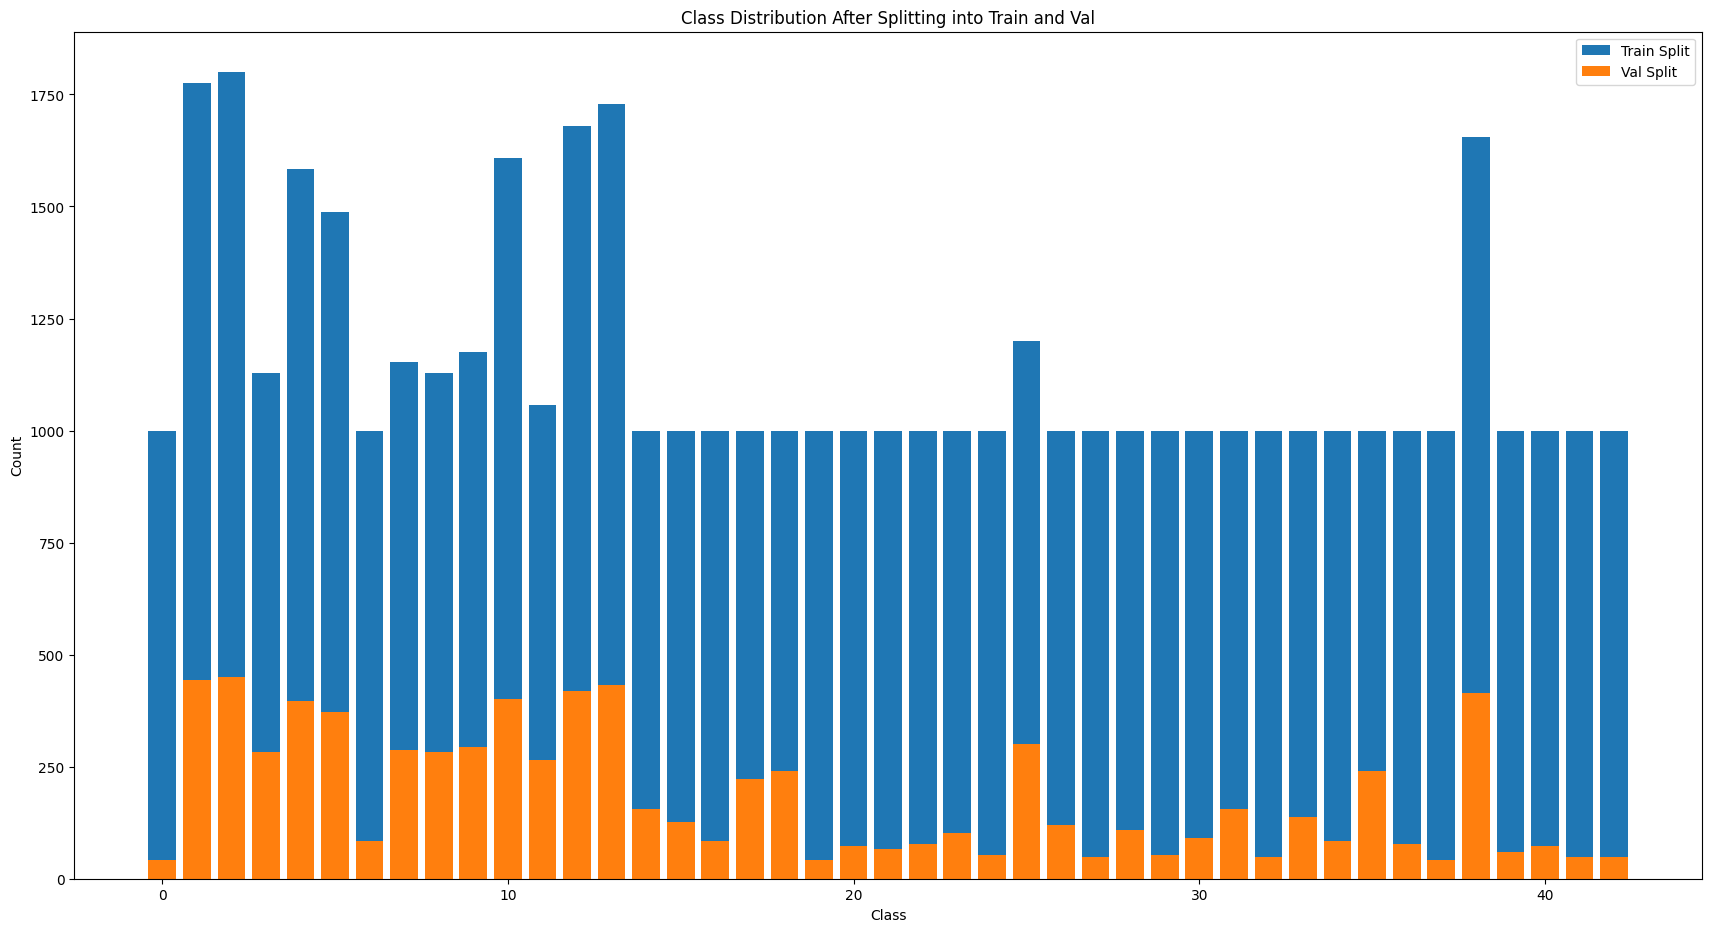

In [24]:
y_train_classes = np.argmax(y_train, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

train_unique, y_train_count = np.unique(y_train_classes, return_counts=True)
val_unique, y_val_count = np.unique(y_val_classes, return_counts=True)

plt.figure(figsize=(21, 11))
plt.bar(train_unique, y_train_count)
plt.bar(val_unique, y_val_count)
plt.legend(['Train Split', 'Val Split'], loc='upper right')
plt.title("Class Distribution After Splitting into Train and Val")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [25]:
test_unique, y_test_count = np.unique(y_test, return_counts = True)

In [26]:
y_val_labels = np.argmax(y_val, axis=1)
val_unique, y_val_count = np.unique(y_val_labels, return_counts=True)

In [29]:
df_balance['val'] = y_val_count
df_balance['val_ratio'] = df_balance['val'] / df_balance['total']
df_balance['train_ratio'] = df_balance['train_ratio'] - df_balance['val_ratio']

<Axes: title={'center': 'Train Val Test Split'}, xlabel='labels'>

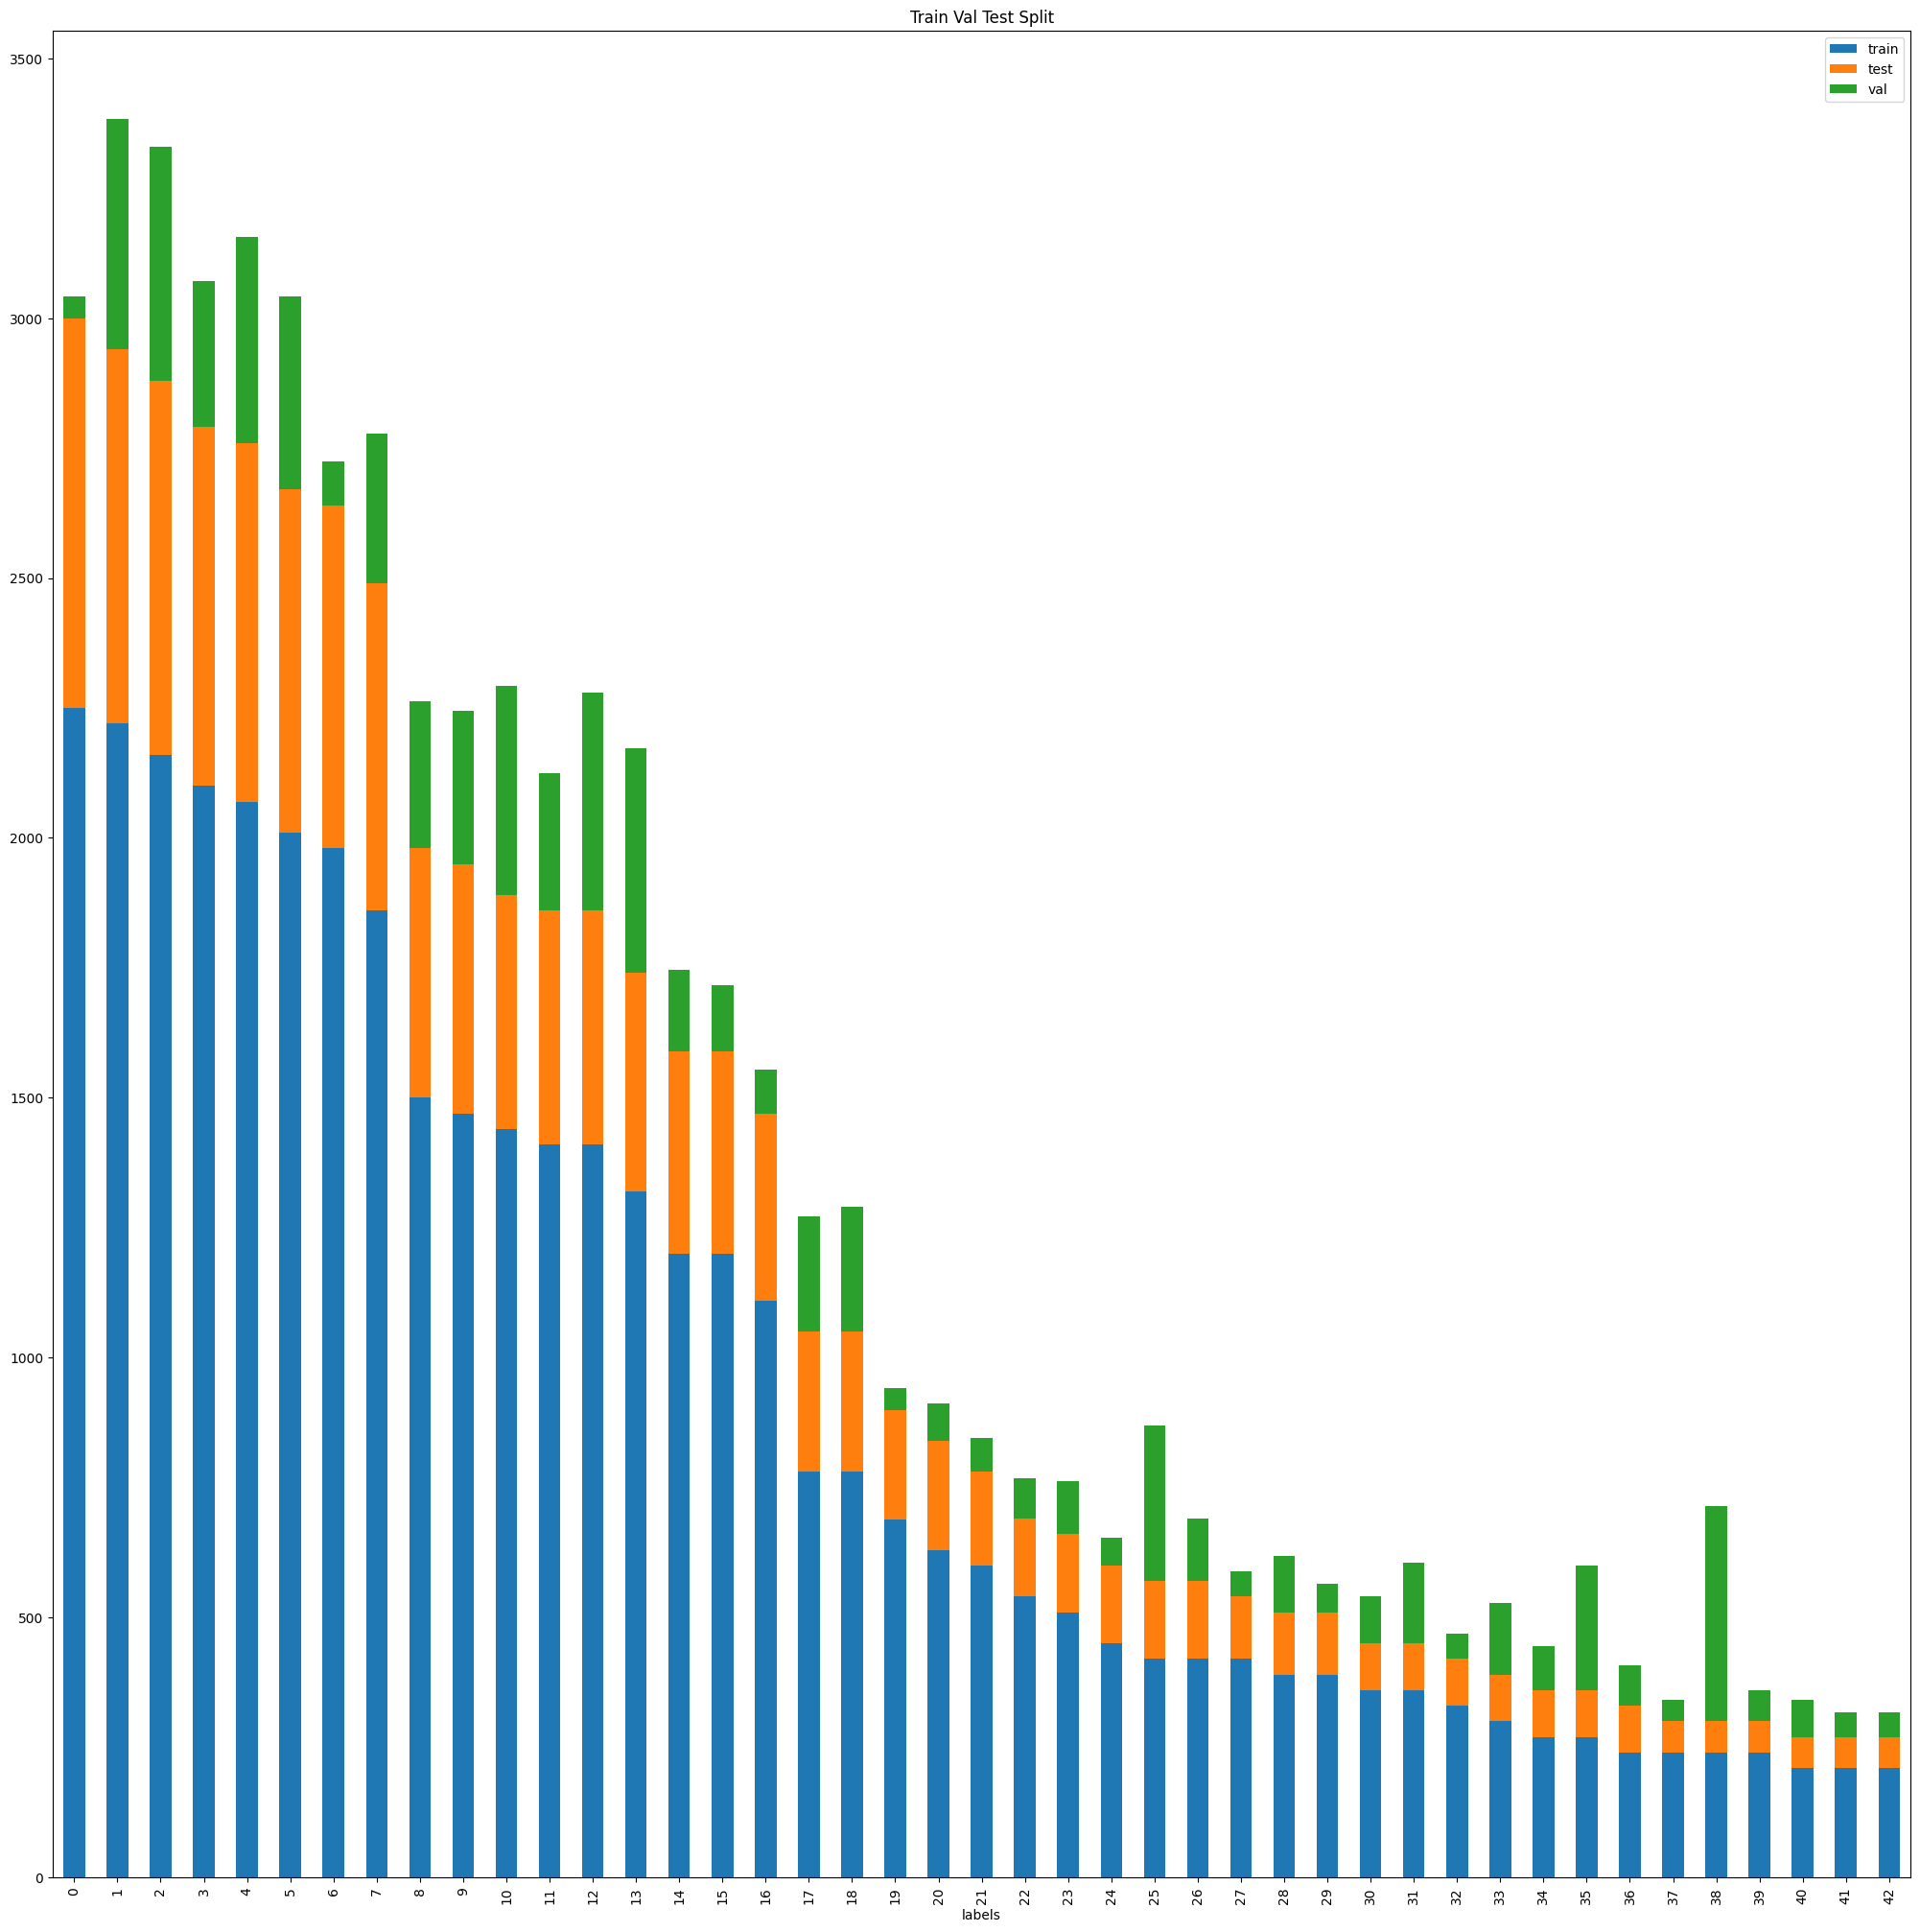

In [30]:
df_balance.plot.bar(x = 'labels', y = ['train', 'test', 'val'], figsize = (25, 25), stacked = True, title = "Train Val Test Split")

# Model Architectures

In [20]:
def get_custom_cnn():
    """
    Custom CNN architecture with regularization and dropout.
    """
    model = tf.keras.Sequential([
        # First Convolutional Block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Second Convolutional Block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Third Convolutional Block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Dense Layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_CATEGORIES, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


def create_transfer_model(base_model_class, model_name):
    """
    Create a transfer learning model using pretrained architecture.
    """
    base = base_model_class(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
    )
    base.trainable = False

    model = tf.keras.Sequential([
        base,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_CATEGORIES, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Explanation of the Custom CNN Model

The custom CNN model defined in `get_custom_cnn()` is a deep convolutional neural network tailored for traffic sign classification. Here are its key design choices:

1. **Convolutional Blocks**: 
    - The model uses three convolutional blocks with increasing filter sizes (32, 64, 128), each followed by batch normalization and max pooling. 
    - This structure allows the network to learn hierarchical features, from simple edges to complex shapes.

2. **Batch Normalization**:
    - Batch normalization layers after each convolution help stabilize and accelerate training by normalizing activations.

3. **Pooling Layers**:
    - Max pooling reduces spatial dimensions, controls overfitting, and improves computational efficiency.

4. **Dense Layers**:
    - After flattening, a dense layer with 512 units and ReLU activation is used for high-level feature learning.
    - Dropout (0.5) is applied to reduce overfitting.

5. **Output Layer**:
    - The final dense layer uses softmax activation to output class probabilities for all 43 traffic sign categories.

6. **Regularization**:
    - Dropout and batch normalization together help prevent overfitting and improve generalization.

7. **Compilation**:
    - The model is compiled with the Adam optimizer and categorical cross-entropy loss, suitable for multi-class classification.

**Summary**:  
This custom CNN is designed to balance model complexity and generalization, making it effective for image classification tasks like traffic sign recognition, especially when trained on moderately sized datasets.

In [ ]:
def plot_training_histories(histories, filename='training_history.png', show_plot=True, save_plot=True):
    """
    Enhanced plotting of training histories with additional metrics and styling.

    Args:
        histories (dict): Dictionary of model training histories
        filename (str): Path to save the plot image
        show_plot (bool): Whether to display the plot
        save_plot (bool): Whether to save the plot to file
    """
    # Create figure with 1x2 grid for accuracy and loss plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Set consistent colors for each model
    colors = plt.cm.tab10(np.linspace(0, 1, len(histories)))

    for (name, history), color in zip(histories.items(), colors):
        epochs = range(1, len(history['accuracy']) + 1)

        # Accuracy plot
        ax1.plot(epochs, history['accuracy'], '--', color=color, alpha=0.8, label=f'{name} Train')
        ax1.plot(epochs, history['val_accuracy'], '-', color=color, alpha=0.8, label=f'{name} Val')

        # Loss plot
        ax2.plot(epochs, history['loss'], '--', color=color, alpha=0.8)
        ax2.plot(epochs, history['val_loss'], '-', color=color, alpha=0.8)

    # Configure accuracy plot
    ax1.set_title('Training vs Validation Accuracy', pad=10)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right', framealpha=0.9)
    ax1.grid(True, alpha=0.3)
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Configure loss plot
    ax2.set_title('Training vs Validation Loss', pad=10)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.grid(True, alpha=0.3)
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout(pad=3.0)

    # Save plot if requested
    if save_plot:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {filename}")

    # Show plot if requested
    if show_plot:
        plt.show()
    else:
        plt.close(fig)  # Only close if not showing

def display_results(results, filename='model_comparison_results.csv'):
    """
    Enhanced results display with comprehensive metrics and formatting.

    Args:
        results (dict): Dictionary of model evaluation results
        filename (str): Path to save the CSV results
    """
    # Create DataFrame with sorted columns
    df = pd.DataFrame(results).T

    # Define column order (putting key metrics first)
    metric_order = ['test_accuracy', 'test_loss', 'inference_time',
                   'model_size', 'memory_usage']
    existing_cols = [col for col in metric_order if col in df.columns]
    other_cols = [col for col in df.columns if col not in metric_order]
    df = df[existing_cols + other_cols]

    # Format numbers
    float_cols = df.select_dtypes(include=['float']).columns
    df[float_cols] = df[float_cols].round(4)

    # Store for potential use in plotting
    plot_training_histories.results_df = df

    # Print formatted output
    print("\n" + "="*80)
    print("MODEL COMPARISON RESULTS".center(80))
    print("="*80)

    # Print markdown table
    print("\nDetailed Metrics:")
    print(df.to_markdown(tablefmt="grid", stralign="center", numalign="center"))

    # Print key comparison
    print("\nKey Comparisons:")
    key_df = df[['test_accuracy', 'inference_time', 'model_size']].copy()
    key_df['accuracy_rank'] = key_df['test_accuracy'].rank(ascending=False)
    key_df['speed_rank'] = key_df['inference_time'].rank()
    key_df['size_rank'] = key_df['model_size'].rank()
    print(key_df.to_markdown(tablefmt="grid", stralign="center", numalign="center"))

    # Save results
    df.to_csv(filename, float_format="%.4f")
    print(f"\nResults saved to {filename}")

* The two functions above are:
    1. plot_training_histories
    2. display_results

* plot_training_histories(histories, filename, show_plot, save_plot): 
    - Plots training and validation accuracy and loss curves for multiple models.
    - Accepts a dictionary of training histories (from Keras .fit()) for each model.
    - Uses different colors for each model, and shows both train and validation metrics.
    - Saves the plot as an image file if requested, and can display or close the plot.

* display_results(results, filename):
    - Displays a summary table of model evaluation metrics (accuracy, loss, inference time, model size, memory usage).
    - Formats the results as a markdown table for easy comparison.
    - Ranks models by accuracy, inference speed, and size.
    - Saves the results to a CSV file for further analysis.

* In summary, these functions help visualize model training progress and compare the final performance of different models in a clear, organized way.

In [22]:
def evaluate_model_metrics(model, x_test):
    """
    Evaluate model performance metrics including inference time and resource usage.
    """
    # Warm-up run
    model.predict(x_test[:10])

    # Measure inference time
    start_time = time.time()
    model.predict(x_test[:1000])
    inference_time = (time.time() - start_time) / len(x_test.shape[:1000])

    # Get model size
    model.save('temp_model.h5')
    model_size = os.path.getsize('temp_model.h5') / (1024 * 1024)  # Size in MB
    os.remove('temp_model.h5')

    # Measure memory usage
    memory_usage = psutil.Process().memory_info().rss / (1024 * 1024)  # MB

    return {
        'inference_time': inference_time,
        'model_size': model_size,
        'memory_usage': memory_usage
    }

* The function evaluate_model_metrics(model, x_test) evaluates a trained model's performance and resource usage.
It performs the following steps:
    1. Runs a warm-up prediction to initialize the model.
    2. Measures the average inference time per sample on a subset of test data.
    3. Saves the model temporarily to disk to calculate its file size in megabytes.
    4. Measures the current memory usage of the process in megabytes.
    5. Returns a dictionary containing inference time, model size, and memory usage.
* This helps compare models not just by accuracy, but also by speed and resource efficiency.

In [ ]:
# Add selective augmentation (recommended)
def augment_minority_classes_split(X_train, y_train, threshold=1000):
    """Augment only classes with less than threshold samples in training set"""
    class_indices = np.argmax(y_train, axis=1)
    unique_classes, counts = np.unique(class_indices, return_counts=True)

    # Find classes needing augmentation
    minority_classes = [cls for cls, count in zip(unique_classes, counts) if count < threshold]

    if not minority_classes:
        return X_train, y_train

    datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        fill_mode='nearest'
    )

    augmented_data = list(X_train)
    augmented_labels = list(y_train)

    for cls in minority_classes:
        class_mask = class_indices == cls
        class_data = X_train[class_mask]
        class_labels = y_train[class_mask]

        current_count = np.sum(class_mask)
        needed = threshold - current_count

        # Generate needed samples
        for i in range(needed):
            idx = i % len(class_data)
            img = class_data[idx:idx+1]

            aug_img = next(datagen.flow(img, batch_size=1))[0]
            augmented_data.append(aug_img)
            augmented_labels.append(class_labels[idx])

    return np.array(augmented_data), np.array(augmented_labels)

# Modify your train_with_augmentation to remove the extra augmentation and add model saving:
def train_with_augmentation(x_train, y_train, x_val, y_val, x_test, y_test,
                           model, model_name, epochs=EPOCHS, batch_size=BATCH_SIZE):
    """Train model and save best custom CNN"""

    # Create callbacks
    callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

    # Add model saving for custom CNN only
    if model_name == 'Custom_CNN':
        os.makedirs('saved_models', exist_ok=True)
        callbacks.append(
            ModelCheckpoint(
                filepath='saved_models/best_custom_cnn.h5',
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            )
        )

    # Train the model with validation data
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=callbacks
    )

    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    metrics = evaluate_model_metrics(model, x_test)

    return {
        'test_accuracy': test_accuracy*100,
        'test_loss': test_loss,
        **metrics
    }, history.history

def experiment_with_models(x_train, y_train, x_val, y_val, x_test, y_test):
    """
    Train and compare different model architectures with proper augmentation and validation
    """
    # Create models directory if not exists
    os.makedirs('models', exist_ok=True)

    models = {
        'Custom_CNN': get_custom_cnn(),
        'ResNet50': create_transfer_model(ResNet50, 'resnet50'),
        'MobileNetV2': create_transfer_model(MobileNetV2, 'mobilenetv2')
    }

    results = {}
    histories = {}

    for name, model in models.items():
        print(f"\nTraining {name} with augmentation...")
        results[name], histories[name] = train_with_augmentation(
            x_train, y_train,
            x_val, y_val,
            x_test, y_test,
            model, name
        )

    return results, histories

# Augment minority classes in training set
X_train, y_train = augment_minority_classes_split(X_train, y_train)

print("\nStarting experiment with proper train/val/test split...")
results, histories = experiment_with_models(
    X_train, y_train,
    X_val, y_val,
    X_test, y_test
)

# Save and display results
display_results(results)


Starting experiment with proper train/val/test split...

Training Custom_CNN with augmentation...
Epoch 1/30
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6800 - loss: 1.2431
Epoch 1: val_accuracy improved from -inf to 0.97947, saving model to saved_models/best_custom_cnn.h5


1537/1537 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.6801 - loss: 1.2426 - val_accuracy: 0.9795 - val_loss: 0.0744
Epoch 2/30
1534/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9731 - loss: 0.0916
Epoch 2: val_accuracy did not improve from 0.97947
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9731 - loss: 0.0915 - val_accuracy: 0.9716 - val_loss: 0.1118
Epoch 3/30
1535/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9831 - loss: 0.0560
Epoch 3: val_accuracy improved from 0.97947 to 0.98840, saving model to saved_models/best_custom_cnn.h5


1537/1537 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9831 - loss: 0.0560 - val_accuracy: 0.9884 - val_loss: 0.0382
Epoch 4/30
1532/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9857 - loss: 0.0449
Epoch 4: val_accuracy improved from 0.98840 to 0.98865, saving model to saved_models/best_custom_cnn.h5


1537/1537 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9857 - loss: 0.0449 - val_accuracy: 0.9887 - val_loss: 0.0348
Epoch 5/30
1531/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9865 - loss: 0.0423
Epoch 5: val_accuracy improved from 0.98865 to 0.99375, saving model to saved_models/best_custom_cnn.h5


1537/1537 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9865 - loss: 0.0423 - val_accuracy: 0.9938 - val_loss: 0.0221
Epoch 6/30
1535/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9916 - loss: 0.0281
Epoch 6: val_accuracy did not improve from 0.99375
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9916 - loss: 0.0281 - val_accuracy: 0.9858 - val_loss: 0.0827
Epoch 7/30
1530/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9915 - loss: 0.0258
Epoch 7: val_accuracy did not improve from 0.99375
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9915 - loss: 0.0258 - val_accuracy: 0.9908 - val_loss: 0.0319
Epoch 8/30
1535/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9947 - loss: 0.0168
Epoch 8: val_accuracy improved from 0.99375 to 0.99490, saving model to saved_models/best_custom_cnn.h5


1537/1537 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9946 - loss: 0.0168 - val_accuracy: 0.9949 - val_loss: 0.0203
Epoch 9/30
1530/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9936 - loss: 0.0202
Epoch 9: val_accuracy did not improve from 0.99490
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9936 - loss: 0.0202 - val_accuracy: 0.9934 - val_loss: 0.0210
Epoch 10/30
1533/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9962 - loss: 0.0119
Epoch 10: val_accuracy did not improve from 0.99490
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9962 - loss: 0.0119 - val_accuracy: 0.9945 - val_loss: 0.0177
Epoch 11/30
1532/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9960 - loss: 0.0129
Epoch 11: val_accuracy did not improve from 0.99490
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9960 - loss: 0.0129 - val_accuracy: 0.9943 - val_loss: 0.0190
Epoch 12/30
1534/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9961 - loss: 0.0116
Epoch 12: va

1537/1537 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9957 - loss: 0.0143 - val_accuracy: 0.9969 - val_loss: 0.0137
Epoch 14/30
1529/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9964 - loss: 0.0119
Epoch 14: val_accuracy did not improve from 0.99694
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9964 - loss: 0.0119 - val_accuracy: 0.9959 - val_loss: 0.0163
Epoch 15/30
1536/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9962 - loss: 0.0116
Epoch 15: val_accuracy did not improve from 0.99694
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9962 - loss: 0.0116 - val_accuracy: 0.9945 - val_loss: 0.0216
Epoch 16/30
1531/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9970 - loss: 0.0114
Epoch 16: val_accuracy did not improve from 0.99694
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9970 - loss: 0.0114 - val_accuracy: 0.9944 - val_loss: 0.0189
Epoch 17/30
1532/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9969 - loss: 0.0102
Epoch 17: v

1537/1537 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9969 - loss: 0.0102 - val_accuracy: 0.9976 - val_loss: 0.0137
Epoch 18/30
1535/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9963 - loss: 0.0114
Epoch 18: val_accuracy did not improve from 0.99758
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9963 - loss: 0.0114 - val_accuracy: 0.9944 - val_loss: 0.0217
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step



Training ResNet50 with augmentation...
Epoch 1/30
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 46s 22ms/step - accuracy: 0.2349 - loss: 2.9266 - val_accuracy: 0.2204 - val_loss: 3.4960
Epoch 2/30
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.4382 - loss: 1.9868 - val_accuracy: 0.3187 - val_loss: 3.1091
Epoch 3/30
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 44s 16ms/step - accuracy: 0.4782 - loss: 1.7960 - val_accuracy: 0.3118 - val_loss: 3.2400
Epoch 4/30
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.5009 - loss: 1.7261 - val_accuracy: 0.3698 - val_loss: 2.9061
Epoch 5/30
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 0.5230 - loss: 1.6379 - val_accuracy: 0.2770 - val_loss: 3.6601
Epoch 6/30
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.5426 - loss: 1.5849 - val_accuracy: 0.4059 - val_loss: 2.6035
Epoch 7/30
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - accuracy: 0.5494 - loss: 1.5478 - val_accuracy: 0.3497 - val_loss: 3.1615
Epoch 8/30
1537/1537 ━━━━━━━━━━━━━━━


Training MobileNetV2 with augmentation...
Epoch 1/30
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 37s 17ms/step - accuracy: 0.3913 - loss: 2.2900 - val_accuracy: 0.6307 - val_loss: 1.1522
Epoch 2/30
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.6316 - loss: 1.1699 - val_accuracy: 0.6885 - val_loss: 0.9466
Epoch 3/30
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.6822 - loss: 0.9869 - val_accuracy: 0.7075 - val_loss: 0.8787
Epoch 4/30
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.7139 - loss: 0.8797 - val_accuracy: 0.7337 - val_loss: 0.7989
Epoch 5/30
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.7463 - loss: 0.7750 - val_accuracy: 0.7470 - val_loss: 0.7606
Epoch 6/30
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.7599 - loss: 0.7214 - val_accuracy: 0.7745 - val_loss: 0.6777
Epoch 7/30
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.7800 - loss: 0.6663 - val_accuracy: 0.7794 - val_loss: 0.6791
Epoch 8/30
1537/1537 ━━━━━━━━━━━━━━━━━━


                            MODEL COMPARISON RESULTS                            

Detailed Metrics:
+-------------+-----------------+-------------+------------------+--------------+----------------+
|             |  test_accuracy  |  test_loss  |  inference_time  |  model_size  |  memory_usage  |
+=============+=================+=============+==================+==============+================+
| Custom_CNN  |     97.9097     |    0.094    |      0.3314      |   13.4282    |    8026.26     |
+-------------+-----------------+-------------+------------------+--------------+----------------+
|  ResNet50   |     35.4632     |   2.7867    |      2.5799      |   102.645    |     8457.2     |
+-------------+-----------------+-------------+------------------+--------------+----------------+
| MobileNetV2 |     52.3991     |   2.4344    |      1.3316      |   16.7491    |    8586.24     |
+-------------+-----------------+-------------+------------------+--------------+----------------+

Key Com

# Explanation of Functions and Augmentation Strategy

The previous cell defines and utilizes several key functions to improve model training and evaluation, with a focus on addressing class imbalance through selective augmentation:

### 1. `augment_minority_classes_split`
- **Purpose:** Augments only those classes in the training set that have fewer samples than a specified threshold (default: 1000).
- **How it works:** 
    - Identifies minority classes by counting samples per class.
    - Uses `ImageDataGenerator` to generate new images for these classes via random transformations (rotation, zoom, shifts).
    - Augmented images are added to the training set until each minority class reaches the threshold.
- **Benefit:** This targeted augmentation helps balance the dataset, improving model generalization and performance on underrepresented classes.

### 2. `train_with_augmentation`
- **Purpose:** Trains a given model using the (possibly augmented) training data, with validation and test evaluation.
- **Features:**
    - Uses early stopping to prevent overfitting.
    - Saves the best model weights for the custom CNN.
    - Returns test accuracy, loss, and resource metrics (inference time, model size, memory usage).
- **Augmentation Usage:** The function expects the training data to be already augmented (as done by `augment_minority_classes_split`).

### 3. `experiment_with_models`
- **Purpose:** Trains and compares multiple model architectures (Custom CNN, ResNet50, MobileNetV2) using the same data and evaluation pipeline.
- **How it works:** 
    - Initializes each model.
    - Trains each model using `train_with_augmentation`.
    - Collects results and training histories for comparison.

### 4. Augmentation Workflow
- **Step 1:** The training data (`X_train`, `y_train`) is first passed through `augment_minority_classes_split` to balance the classes.
- **Step 2:** The augmented data is then used to train all models in `experiment_with_models`.
- **Step 3:** Results and training histories are visualized and compared.

**Summary:**  
The notebook follows a best-practice approach by applying augmentation only to underrepresented classes, ensuring a balanced training set without unnecessary duplication. This targeted strategy, combined with robust training and evaluation functions, leads to fairer and more effective model comparisons.

Plot saved to training_history.png


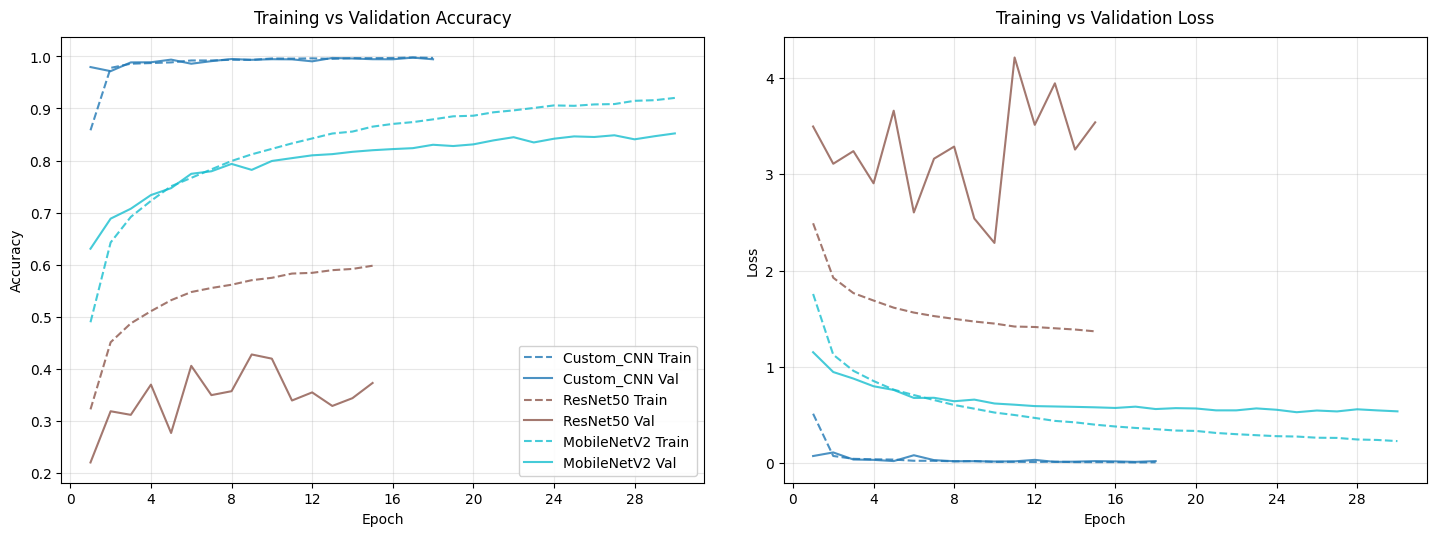

In [33]:
plot_training_histories(histories)

#  Workflow

The notebook follows a structured workflow for traffic sign recognition:

- **Data Loading & Exploration:**  
    The dataset is loaded, explored, and visualized to understand class distributions, image properties, and potential imbalances.
- **Preprocessing & Augmentation:**  
    Images are resized and normalized. Selective augmentation is applied to minority classes to address class imbalance.
- **Model Building:**  
    Multiple architectures are defined, including a custom CNN and transfer learning models (ResNet50, MobileNetV2).
- **Training & Evaluation:**  
    Models are trained with early stopping and best model saving. Performance is evaluated on validation and test sets, with metrics such as accuracy, loss, inference time, model size, and memory usage.
- **Visualization & Comparison:**  
    Training histories and results are visualized and compared to identify the best-performing model.

#  Future Improvements

- **Hyperparameter Tuning:**  
    Explore advanced optimization techniques (e.g., learning rate schedules, different optimizers) for further performance gains.
- **Ensemble Methods:**  
    Combine predictions from multiple models to boost accuracy and robustness.
- **Advanced Augmentation:**  
    Incorporate more sophisticated augmentation techniques or synthetic data generation.
- **Cross Validation:**  
    Implement cross-validation for more robust evaluation
- **Improvements in Transfer Learning:**  
    Experiment with additional architectures (VGG16, EfficientNet).
    Implement gradual unfreezing for transfer learning
